In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime
import os
from skimage.transform import resize
import random
from tensorflow.python.keras.utils.data_utils import Sequence
from scipy.ndimage import zoom
from scipy.ndimage import shift
from skimage.transform import rotate
from sklearn import metrics

In [2]:
#input variables
target_path = "C:\\Users\\awe2\\DL_DES-master\\data\\sdss-galaxyzoo\\high_certainty\\sdss_metadata\\"

#path = 'image_arrays_new_new\\'
#validation_path = path + 'validation'
#training_path = path + 'training'
#test_path = path + 'test'

#model variables
batch_size = 32 #
#epoch_number = 50
learning_rate = 1e-4 

params_train = {'dim': (120,120),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 5,
          'shuffle': True}

params_test = {'dim': (120,120),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 5,
          'shuffle': False}


#more parameters means more prone to overfitting, and I am 5/3 times worse on parameters compared to the paper I have
#based this on. (5 bands instead of 3) I need to find ways to add more regularization, or otherwise might try reducing my number
#of layers to reduce the number of parameters.

In [3]:
#https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions/48097478
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [4]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):

    def __init__(self, list_IDs, labels, batch_size=32, dim=(120,120), n_channels=3,
                 n_classes=2, shuffle=True):
     #   'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
    #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
    #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
    

      # Generate data and perform augmentation
        for i, ID in enumerate(list_IDs_temp):
            
          # Store sample
            X[i,] = np.load('HP_inputs/' + ID + '.npy')
            
            #I messed up when generating my inputs on the order of the band; I want to train the model in the usual bands:
            
            #u_filter = X[i,:,:,0]
            #g_filter = X[i,:,:,1]
            i_filter = X[i,:,:,2]
            r_filter = X[i,:,:,3]
            #z_filter = X[i,:,:,4]

            #X[i,:,:,0] = u_filter
            #X[i,:,:,1] = g_filter
            X[i,:,:,2] = r_filter
            X[i,:,:,3] = i_filter
            #X[i,:,:,4] = z_filter              
            #flip
            if random.random() > 0.5:
                X[i,] = np.flip(X[i,],0)
            if random.random() > 0.5:
                X[i,] = np.flip(X[i,],1)
            
            #shift
            if random.random() > 0.5 :
                X[i,] = shift(X[i,], (4,0,0), mode='nearest')
            elif random.random() > 0.5 :
                X[i,] = shift(X[i,], (-4,0,0), mode='nearest')
                              
            if random.random() > 0.5 :
                X[i,] = shift(X[i,], (0,4,0), mode='nearest')
            elif random.random() > 0.5 :
                X[i,] = shift(X[i,], (0,-4,0), mode='nearest')
          
            #zoom in/out
            zoom_factor = random.uniform(0.75,1.3)
            X[i,] = clipped_zoom(X[i,],zoom_factor)
            
            #rotate
            angle = 45*random.random()
            X[i,] = rotate(X[i,], angle=angle, mode='reflect')
            
            # Store class
            y[i] = self.labels[ID]
    
        if self.n_classes > 2:
            return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        else:
            return X, y

    def __len__(self):
    #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
    #  'Generate one batch of data'
      # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

      # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [5]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class LP_DataGenerator(Sequence):

    def __init__(self, list_IDs, labels, batch_size=32, dim=(120,120), n_channels=3,
                 n_classes=2, shuffle=False):
     #   'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
    #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
    #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
    

      # Generate data and perform augmentation
        for i, ID in enumerate(list_IDs_temp):
            
          # Store sample
            X[i,] = np.load('LP_inputs/' + ID + '.npy')
                        
            #flip
            if random.random() > 0.5:
                X[i,] = np.flip(X[i,],0)
            if random.random() > 0.5:
                X[i,] = np.flip(X[i,],1)
            
            #shift
            if random.random() > 0.5 :
                X[i,] = shift(X[i,], (4,0,0), mode='nearest')
            elif random.random() > 0.5 :
                X[i,] = shift(X[i,], (-4,0,0), mode='nearest')
                              
            if random.random() > 0.5 :
                X[i,] = shift(X[i,], (0,4,0), mode='nearest')
            elif random.random() > 0.5 :
                X[i,] = shift(X[i,], (0,-4,0), mode='nearest')
          
            #zoom in/out
            zoom_factor = random.uniform(0.75,1.3)
            X[i,] = clipped_zoom(X[i,],zoom_factor)
            
            #rotate
            angle = 45*random.random()
            X[i,] = rotate(X[i,], angle=angle, mode='reflect')
            
            # Store class
            y[i] = self.labels[ID]
    
        if self.n_classes > 2:
            return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        else:
            return X, y

    def __len__(self):
    #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
    #  'Generate one batch of data'
      # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

      # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [6]:
#generate the targets.
a = []
for file in (os.listdir(target_path)):
    target = pd.read_csv(target_path+file,usecols=[14])
    a.append((target["target"].values))
targets = np.concatenate([a[0],a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8]])

In [7]:
#generate the LP test targets
b = []
for file in os.listdir("C:\\Users\\awe2\\try_this\\NEW_METADATA\\LOW_CERTAINTY\\"):
    if file.endswith('.csv'):
        target = pd.read_csv("C:\\Users\\awe2\\try_this\\NEW_METADATA\\LOW_CERTAINTY\\" + file, usecols=[13])
        b.append((target["Spiral"].values))
LP_targets = np.concatenate([b[0],b[1]])

In [8]:
"""
LP_labels = {}
for i in range(len(LP_targets)):
    string = "LP_{}.npy".format(str(i).zfill(5))
    if string in os.listdir("LP_inputs"):
        name = "LP_{}".format(str(i).zfill(5))
        LP_labels.update({name:LP_targets[i]})
        
f = open("LP_labels.txt","w")
f.write( str(LP_labels) )
f.close()
"""
with open("LP_labels.txt","r") as inf:
    LP_labels = eval(inf.read())

In [9]:
#targets each correspond to an array called: HP_*****.npy in folder HP_inputs// where ***** is zfilled starting at 00000
#we can use os.listdir to generate strings of the correct iterator

#we then need to sort out where each of these files will go.
#for i,file in enumerate(os.listdir("HP_inputs"))

"""
labels = {}
for i in range(len(targets)):
    string = "HP_{}.npy".format(str(i).zfill(5))
    if string in os.listdir("HP_inputs"):
        name = "HP_{}".format(str(i).zfill(5))
        labels.update({name:targets[i]})
        
f = open("HP_inputs\\labels.txt","w")
f.write( str(labels) )
f.close()
"""
with open("labels.txt","r") as inf:
    labels = eval(inf.read())

In [10]:
#now we shuffle our data list, and partition into train, test, and validation sets.
data_list = os.listdir("HP_inputs")
random.shuffle(data_list)
#we want 20% of the data reserved for testing, and then another 15% reserved for validation.
top_index = len(data_list)
first_index = int(round(top_index * 0.65))
second_index = int(round(top_index * 0.15)) + first_index

train_list = data_list[0:first_index]
val_list = data_list[first_index:second_index]
test_list = data_list[second_index::]

for i,file in enumerate(train_list):
    train_list[i] = file.split('.')[0]
for i,file in enumerate(val_list):
    val_list[i] = file.split('.')[0]
for i,file in enumerate(test_list):
    test_list[i] = file.split('.')[0]

partition = {'train':train_list,'validation':val_list,'test':test_list}

In [11]:
#now for the LP inputs
LP_data_list = os.listdir("LP_inputs")
random.shuffle(LP_data_list)

for i,file in enumerate(LP_data_list):
    LP_data_list[i] = file.split('.')[0]
    
LP_partition = {'test':LP_data_list}

LP_test_generator = LP_DataGenerator(LP_partition['test'], LP_labels, **params_test)

In [12]:
training_generator = DataGenerator(partition['train'], labels, **params_train)
validation_generator = DataGenerator(partition['validation'], labels, **params_train)
test_generator = DataGenerator(partition['test'], labels, **params_test)

In [13]:
#so this is pretty neat, you can create a keras callback to display on tensorboard using a simplified summary tf api

#and also this is an example of how to change the lr on the fly, which is pretty handy
#https://keras.io/callbacks/


"""
    file_writer = tf.summary.create_file_writer(logdir + "/metrics")
    file_writer.set_as_default()
"""
def lr_schedule(epoch,lr):

#Returns a custom learning rate that decreases as epochs progress.
    if epoch > 1:
        lr = 1e-4
    if epoch > 7:
        lr = 1e-5
    if epoch > 12:
        lr = 1e-6
    if epoch > 20:
        lr = 5e-6

    tf.summary.scalar('learning_rate', tensor=lr)
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

#logdir="summaries/scalars/" + str(datetime.datetime.now().timestamp())
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
#                                                   histogram_freq=1,
#                                                   write_graph=False,
#                                                   write_grads=True,)
#                                                   #write_images=True)
#will it still print stuff

In [14]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    keras.backend.get_session().run(tf.local_variables_initializer())
    return auc

In [15]:
def create_model(learning_rate=learning_rate):
    
    model = keras.Sequential([])
    
    model.add(keras.layers.Conv2D(input_shape=(120,120,5),filters=32,kernel_size=6,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.5))
    
    model.add(keras.layers.Conv2D(filters=64,kernel_size=5,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=2,))
    model.add(keras.layers.Dropout(rate=0.25)) #best = 0.25
    
    model.add(keras.layers.Conv2D(filters=128,kernel_size=2,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=2,))
    model.add(keras.layers.Dropout(rate=0.25)) #best = 0.25
    
    
    model.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.35)) #best = 0.35

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=64,activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(units=1,activation=tf.nn.sigmoid)) #tf.nn.softmax for categorical, sigmoid for binary
    
    adam = keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy',auc,'FalsePositives','TruePositives','FalseNegatives','TrueNegatives']) 
    return(model)

In [16]:
keras.backend.clear_session()
model = create_model(learning_rate = learning_rate)

W0820 09:43:07.933651  6764 deprecation.py:506] From C:\Users\awe2\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 09:43:08.265651  6764 deprecation.py:323] From C:\Users\awe2\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\metrics_impl.py:809: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0820 09:43:11.010651  6764 deprecation.py:323] From C:\Users\awe2\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed

In [17]:
steps_to_take = int(len(train_list)/batch_size)
val_steps_to_take = int(len(val_list)/batch_size)
test_steps_to_take = int(len(test_list)/batch_size)
LP_test_steps_to_take = int(len(LP_data_list)/batch_size)
                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.

print(steps_to_take)
print(val_steps_to_take)
print(test_steps_to_take)

785
181
241


In [28]:
#another callback
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-8, verbose=1, mode='min')

In [18]:
filepath = "models//5-band-CNN-correct-filters.hdf5"
ModelCheckpointCB = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [30]:
hist = model.fit_generator(generator=training_generator,
                    steps_per_epoch=steps_to_take, 
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=val_steps_to_take,
                    verbose=1,
                    callbacks=[ModelCheckpointCB,lr_callback])
                    #callbacks=[tensorboard_callback,lr_callback])

Epoch 1/20


C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


784/785 [============================>.] - ETA: 2s - loss: 1.0354 - acc: 0.5412
Epoch 00001: val_loss improved from inf to 0.64114, saving model to models//5-band-CNN-correct-filters.hdf5
785/785 [==============================] - 2708s 3s/step - loss: 1.0349 - acc: 0.5414 - val_loss: 0.6411 - val_acc: 0.5478
Epoch 2/20
784/785 [============================>.] - ETA: 2s - loss: 0.6090 - acc: 0.6707
Epoch 00002: val_loss improved from 0.64114 to 0.55401, saving model to models//5-band-CNN-correct-filters.hdf5
785/785 [==============================] - 2589s 3s/step - loss: 0.6090 - acc: 0.6707 - val_loss: 0.5540 - val_acc: 0.7623
Epoch 3/20
784/785 [============================>.] - ETA: 2s - loss: 0.5782 - acc: 0.6941
Epoch 00003: val_loss improved from 0.55401 to 0.52204, saving model to models//5-band-CNN-correct-filters.hdf5
785/785 [==============================] - 2579s 3s/step - loss: 0.5782 - acc: 0.6942 - val_loss: 0.5220 - val_acc: 0.8565
Epoch 4/20
784/785 [=================

In [31]:
#test_loss, test_acc = model.evaluate(test_images, test_target)
#print('Test accuracy:', test_acc)
#print('Test loss:', test_loss)

In [37]:
filepath = "models//5-band-CNN-correct-filters-little-more.hdf5"
ModelCheckpointCB = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [39]:
hist_1 = model.fit_generator(generator=training_generator,
                    steps_per_epoch=steps_to_take, 
                    epochs=25,
                    validation_data=validation_generator,
                    validation_steps=val_steps_to_take,
                    verbose=1,
                    initial_epoch=21,
                    callbacks=[ModelCheckpointCB,lr_callback])
                    #callbacks=[tensorboard_callback,lr_callback])

Epoch 22/25
784/785 [============================>.] - ETA: 2s - loss: 0.2327 - acc: 0.8889
Epoch 00022: val_loss improved from inf to 0.12059, saving model to models//5-band-CNN-correct-filters-little-more.hdf5
785/785 [==============================] - 2611s 3s/step - loss: 0.2325 - acc: 0.8890 - val_loss: 0.1206 - val_acc: 0.9574
Epoch 23/25
784/785 [============================>.] - ETA: 2s - loss: 0.2243 - acc: 0.8927
Epoch 00023: val_loss improved from 0.12059 to 0.10971, saving model to models//5-band-CNN-correct-filters-little-more.hdf5
785/785 [==============================] - 2575s 3s/step - loss: 0.2243 - acc: 0.8927 - val_loss: 0.1097 - val_acc: 0.9598
Epoch 24/25
784/785 [============================>.] - ETA: 2s - loss: 0.2218 - acc: 0.8949
Epoch 00024: val_loss did not improve from 0.10971
785/785 [==============================] - 2623s 3s/step - loss: 0.2219 - acc: 0.8949 - val_loss: 0.1215 - val_acc: 0.9553
Epoch 25/25
784/785 [============================>.] - ETA: 

In [32]:
#y_prob = model.predict(X)

In [33]:
#source list
"""
https://arxiv.org/pdf/1711.05744.pdf

https://arxiv.org/pdf/1807.00807.pdf

https://arxiv.org/pdf/1812.02183.pdf

https://github.com/jameslawlor/kaggle_galaxy_zoo/blob/master/galaxy_zoo_keras.ipynb

https://github.com/khanx169/DL_DES

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

#https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions/48097478


#this is where to download galaxies using SQL:
http://skyserver.sdss.org/dr7/en/tools/search/sql.asp
"""

'\nhttps://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/\n\nhttps://arxiv.org/pdf/1711.05744.pdf\n\nhttps://arxiv.org/pdf/1807.00807.pdf\n\nhttps://github.com/jameslawlor/kaggle_galaxy_zoo/blob/master/galaxy_zoo_keras.ipynb\n\nhttps://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly\n\n#https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions/48097478\n\nhttps://distill.pub/2018/building-blocks/ what I want to do with this after it is working.\n'

In [34]:
"""
#model died, I need to implement a save model callback

785/785 [==============================] - 2908s 4s/step - loss: 1.3123 - acc: 0.7658 - val_loss: 0.3576 - val_acc: 0.8862
Epoch 2/15
785/785 [==============================] - 2804s 4s/step - loss: 0.2477 - acc: 0.8998 - val_loss: 0.2727 - val_acc: 0.9176
Epoch 3/15
785/785 [==============================] - 2730s 3s/step - loss: 0.2065 - acc: 0.9165 - val_loss: 0.2536 - val_acc: 0.9209
Epoch 4/15
785/785 [==============================] - 2701s 3s/step - loss: 0.1747 - acc: 0.9301 - val_loss: 0.3375 - val_acc: 0.8857
Epoch 5/15
574/785 [====================>.........] - ETA: 10:50 - loss: 0.1768 - acc: 0.9268
"""

"""
784/785 [============================>.] - ETA: 3s - loss: 1.6864 - acc: 0.5130
Epoch 00001: val_loss improved from inf to 0.68030, saving model to models//5-band-CNN
785/785 [==============================] - 3110s 4s/step - loss: 1.6851 - acc: 0.5130 - val_loss: 0.6803 - val_acc: 0.5537
Epoch 2/10
784/785 [============================>.] - ETA: 2s - loss: 0.6738 - acc: 0.5632
Epoch 00002: val_loss improved from 0.68030 to 0.65193, saving model to models//5-band-CNN
785/785 [==============================] - 2741s 3s/step - loss: 0.6738 - acc: 0.5632 - val_loss: 0.6519 - val_acc: 0.5730
Epoch 3/10
784/785 [============================>.] - ETA: 2s - loss: 0.6481 - acc: 0.5953
Epoch 00003: val_loss improved from 0.65193 to 0.65075, saving model to models//5-band-CNN
785/785 [==============================] - 2677s 3s/step - loss: 0.6480 - acc: 0.5953 - val_loss: 0.6507 - val_acc: 0.6143
Epoch 4/10
784/785 [============================>.] - ETA: 2s - loss: 0.6387 - acc: 0.6149
Epoch 00004: val_loss did not improve from 0.65075
785/785 [==============================] - 2680s 3s/step - loss: 0.6387 - acc: 0.6149 - val_loss: 0.7353 - val_acc: 0.6195
Epoch 5/10
784/785 [============================>.] - ETA: 2s - loss: 0.5721 - acc: 0.6687
Epoch 00005: val_loss improved from 0.65075 to 0.39564, saving model to models//5-band-CNN
785/785 [==============================] - 2673s 3s/step - loss: 0.5718 - acc: 0.6689 - val_loss: 0.3956 - val_acc: 0.8078
Epoch 6/10
784/785 [============================>.] - ETA: 2s - loss: 0.2843 - acc: 0.8756
Epoch 00006: val_loss did not improve from 0.39564
785/785 [==============================] - 2667s 3s/step - loss: 0.2842 - acc: 0.8756 - val_loss: 0.4010 - val_acc: 0.8995
Epoch 7/10
784/785 [============================>.] - ETA: 2s - loss: 0.2060 - acc: 0.9138
Epoch 00007: val_loss did not improve from 0.39564
785/785 [==============================] - 2677s 3s/step - loss: 0.2062 - acc: 0.9138 - val_loss: 0.4315 - val_acc: 0.8881
Epoch 8/10
784/785 [============================>.] - ETA: 2s - loss: 0.1737 - acc: 0.9292
Epoch 00008: val_loss improved from 0.39564 to 0.24017, saving model to models//5-band-CNN
785/785 [==============================] - 2675s 3s/step - loss: 0.1738 - acc: 0.9292 - val_loss: 0.2402 - val_acc: 0.9069
Epoch 9/10
784/785 [============================>.] - ETA: 2s - loss: 0.1621 - acc: 0.9383
Epoch 00009: val_loss did not improve from 0.24017
785/785 [==============================] - 2678s 3s/step - loss: 0.1620 - acc: 0.9383 - val_loss: 0.3230 - val_acc: 0.9297
Epoch 10/10
784/785 [============================>.] - ETA: 2s - loss: 0.1451 - acc: 0.9423
Epoch 00010: val_loss did not improve from 0.24017
785/785 [==============================] - 2667s 3s/step - loss: 0.1451 - acc: 0.9422 - val_loss: 0.2926 - val_acc: 0.9496

Intesting, it seems I am not very stable. I want to run this a few more epochs then throw on xception.

#after running for a few more epochs, I have decided to re-start. it seems after ~13 epochs the model loses all stability. 
#begins increasing dramatically. I am lowering starting LR and placing in a LR scheduler.
"""

'\n784/785 [============================>.] - ETA: 3s - loss: 1.6864 - acc: 0.5130\nEpoch 00001: val_loss improved from inf to 0.68030, saving model to models//5-band-CNN\n785/785 [==============================] - 3110s 4s/step - loss: 1.6851 - acc: 0.5130 - val_loss: 0.6803 - val_acc: 0.5537\nEpoch 2/10\n784/785 [============================>.] - ETA: 2s - loss: 0.6738 - acc: 0.5632\nEpoch 00002: val_loss improved from 0.68030 to 0.65193, saving model to models//5-band-CNN\n785/785 [==============================] - 2741s 3s/step - loss: 0.6738 - acc: 0.5632 - val_loss: 0.6519 - val_acc: 0.5730\nEpoch 3/10\n784/785 [============================>.] - ETA: 2s - loss: 0.6481 - acc: 0.5953\nEpoch 00003: val_loss improved from 0.65193 to 0.65075, saving model to models//5-band-CNN\n785/785 [==============================] - 2677s 3s/step - loss: 0.6480 - acc: 0.5953 - val_loss: 0.6507 - val_acc: 0.6143\nEpoch 4/10\n784/785 [============================>.] - ETA: 2s - loss: 0.6387 - acc: 0

In [35]:
#Here is how to load in a model's weights

#model_new = create_model()
#model_new.load_weights("models//5-band-CNN.h5")

In [26]:
#test model performance:
model.load_weights("models//5-band-CNN-correct-filters-little-more.hdf5")

hist2 = model.evaluate_generator(generator=test_generator,
                    steps=test_steps_to_take, 
                    verbose=1)


C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


241/241 [==============================] - 664s 3s/step - loss: 0.1155 - acc: 0.9593 - auc: 0.9947


In [52]:
print(type(hist2))

NameError: name 'hist2' is not defined

In [31]:
from keras.wrappers.scikit_learn import KerasClassifier
#test on LP inputs.
model.load_weights("models//5-band-CNN-correct-filters-little-more.hdf5")
#need to load in the LP inputs.
y_pred_keras = model.predict_generator(generator=LP_test_generator,
                    steps=LP_test_steps_to_take, 
                    verbose=1)



C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  1/271 [..............................] - ETA: 16:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  2/271 [..............................] - ETA: 16:14

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  3/271 [..............................] - ETA: 15:40

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  4/271 [..............................] - ETA: 15:32

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  5/271 [..............................] - ETA: 15:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  6/271 [..............................] - ETA: 15:42

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  7/271 [..............................] - ETA: 15:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  8/271 [..............................] - ETA: 15:35

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  9/271 [..............................] - ETA: 15:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 10/271 [>.............................] - ETA: 15:24

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 11/271 [>.............................] - ETA: 15:17

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 12/271 [>.............................] - ETA: 15:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 13/271 [>.............................] - ETA: 15:08

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 14/271 [>.............................] - ETA: 15:04

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 15/271 [>.............................] - ETA: 14:57

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 16/271 [>.............................] - ETA: 14:53

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 17/271 [>.............................] - ETA: 14:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 18/271 [>.............................] - ETA: 14:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 19/271 [=>............................] - ETA: 14:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 20/271 [=>............................] - ETA: 14:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 21/271 [=>............................] - ETA: 14:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 22/271 [=>............................] - ETA: 14:27

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 23/271 [=>............................] - ETA: 14:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 24/271 [=>............................] - ETA: 14:17

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 25/271 [=>............................] - ETA: 14:16

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 26/271 [=>............................] - ETA: 14:14

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 27/271 [=>............................] - ETA: 14:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 28/271 [==>...........................] - ETA: 14:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 29/271 [==>...........................] - ETA: 14:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 30/271 [==>...........................] - ETA: 14:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 31/271 [==>...........................] - ETA: 14:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 32/271 [==>...........................] - ETA: 13:55

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 33/271 [==>...........................] - ETA: 13:51

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 34/271 [==>...........................] - ETA: 13:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 35/271 [==>...........................] - ETA: 13:43

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 36/271 [==>...........................] - ETA: 13:40

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 37/271 [===>..........................] - ETA: 13:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 38/271 [===>..........................] - ETA: 13:33

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 39/271 [===>..........................] - ETA: 13:29

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 40/271 [===>..........................] - ETA: 13:26

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 41/271 [===>..........................] - ETA: 13:24

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 42/271 [===>..........................] - ETA: 13:20

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 43/271 [===>..........................] - ETA: 13:17

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 44/271 [===>..........................] - ETA: 13:15

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 45/271 [===>..........................] - ETA: 13:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 46/271 [====>.........................] - ETA: 13:08

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 47/271 [====>.........................] - ETA: 13:05

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 48/271 [====>.........................] - ETA: 13:01

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 49/271 [====>.........................] - ETA: 12:57

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 50/271 [====>.........................] - ETA: 12:55

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 51/271 [====>.........................] - ETA: 12:51

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 52/271 [====>.........................] - ETA: 12:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 53/271 [====>.........................] - ETA: 12:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 54/271 [====>.........................] - ETA: 12:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 55/271 [=====>........................] - ETA: 12:38

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 56/271 [=====>........................] - ETA: 12:34

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 57/271 [=====>........................] - ETA: 12:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 58/271 [=====>........................] - ETA: 12:27

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 59/271 [=====>........................] - ETA: 12:23

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 60/271 [=====>........................] - ETA: 12:20

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 61/271 [=====>........................] - ETA: 12:16

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 62/271 [=====>........................] - ETA: 12:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 63/271 [=====>........................] - ETA: 12:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 64/271 [======>.......................] - ETA: 12:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 65/271 [======>.......................] - ETA: 12:02

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 66/271 [======>.......................] - ETA: 11:58

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 67/271 [======>.......................] - ETA: 11:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 68/271 [======>.......................] - ETA: 11:52

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 69/271 [======>.......................] - ETA: 11:48

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 70/271 [======>.......................] - ETA: 11:45

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 71/271 [======>.......................] - ETA: 11:42

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 72/271 [======>.......................] - ETA: 11:39

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 73/271 [=======>......................] - ETA: 11:35

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 74/271 [=======>......................] - ETA: 11:32

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 75/271 [=======>......................] - ETA: 11:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 76/271 [=======>......................] - ETA: 11:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 77/271 [=======>......................] - ETA: 11:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 78/271 [=======>......................] - ETA: 11:19

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 79/271 [=======>......................] - ETA: 11:15

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 80/271 [=======>......................] - ETA: 11:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 81/271 [=======>......................] - ETA: 11:08

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 82/271 [========>.....................] - ETA: 11:05

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 83/271 [========>.....................] - ETA: 11:01

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 84/271 [========>.....................] - ETA: 10:58

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 85/271 [========>.....................] - ETA: 10:54

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 86/271 [========>.....................] - ETA: 10:50

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 87/271 [========>.....................] - ETA: 10:46

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 88/271 [========>.....................] - ETA: 10:43

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 89/271 [========>.....................] - ETA: 10:39

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 90/271 [========>.....................] - ETA: 10:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 91/271 [=========>....................] - ETA: 10:33

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 92/271 [=========>....................] - ETA: 10:29

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 93/271 [=========>....................] - ETA: 10:26

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 94/271 [=========>....................] - ETA: 10:21

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 95/271 [=========>....................] - ETA: 10:18

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 96/271 [=========>....................] - ETA: 10:14

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 97/271 [=========>....................] - ETA: 10:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 98/271 [=========>....................] - ETA: 10:07

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 99/271 [=========>....................] - ETA: 10:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

100/271 [==========>...................] - ETA: 10:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

101/271 [==========>...................] - ETA: 9:56 

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

102/271 [==========>...................] - ETA: 9:52

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

103/271 [==========>...................] - ETA: 9:49

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

104/271 [==========>...................] - ETA: 9:45

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

105/271 [==========>...................] - ETA: 9:42

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

106/271 [==========>...................] - ETA: 9:38

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

107/271 [==========>...................] - ETA: 9:35

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

108/271 [==========>...................] - ETA: 9:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

109/271 [===========>..................] - ETA: 9:27

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

110/271 [===========>..................] - ETA: 9:24

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

111/271 [===========>..................] - ETA: 9:20

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

112/271 [===========>..................] - ETA: 9:16

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

113/271 [===========>..................] - ETA: 9:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

114/271 [===========>..................] - ETA: 9:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

115/271 [===========>..................] - ETA: 9:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

116/271 [===========>..................] - ETA: 9:02

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

117/271 [===========>..................] - ETA: 8:59

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

118/271 [============>.................] - ETA: 8:55

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

119/271 [============>.................] - ETA: 8:52

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

120/271 [============>.................] - ETA: 8:48

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

121/271 [============>.................] - ETA: 8:45

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

122/271 [============>.................] - ETA: 8:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

123/271 [============>.................] - ETA: 8:38

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

124/271 [============>.................] - ETA: 8:34

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

125/271 [============>.................] - ETA: 8:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

126/271 [============>.................] - ETA: 8:27

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

127/271 [=============>................] - ETA: 8:24

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

128/271 [=============>................] - ETA: 8:20

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

129/271 [=============>................] - ETA: 8:17

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

130/271 [=============>................] - ETA: 8:14

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

131/271 [=============>................] - ETA: 8:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

132/271 [=============>................] - ETA: 8:07

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

133/271 [=============>................] - ETA: 8:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

134/271 [=============>................] - ETA: 8:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

135/271 [=============>................] - ETA: 7:57

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

136/271 [==============>...............] - ETA: 7:53

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

137/271 [==============>...............] - ETA: 7:49

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

138/271 [==============>...............] - ETA: 7:46

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

139/271 [==============>...............] - ETA: 7:42

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

140/271 [==============>...............] - ETA: 7:39

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

141/271 [==============>...............] - ETA: 7:35

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

142/271 [==============>...............] - ETA: 7:32

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

143/271 [==============>...............] - ETA: 7:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

144/271 [==============>...............] - ETA: 7:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

145/271 [===============>..............] - ETA: 7:21

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

146/271 [===============>..............] - ETA: 7:18

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

147/271 [===============>..............] - ETA: 7:14

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

148/271 [===============>..............] - ETA: 7:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

149/271 [===============>..............] - ETA: 7:07

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

150/271 [===============>..............] - ETA: 7:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

151/271 [===============>..............] - ETA: 7:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

152/271 [===============>..............] - ETA: 6:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

153/271 [===============>..............] - ETA: 6:53

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

154/271 [================>.............] - ETA: 6:50

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

155/271 [================>.............] - ETA: 6:46

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

156/271 [================>.............] - ETA: 6:43

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

157/271 [================>.............] - ETA: 6:39

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

158/271 [================>.............] - ETA: 6:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

159/271 [================>.............] - ETA: 6:32

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

160/271 [================>.............] - ETA: 6:29

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

161/271 [================>.............] - ETA: 6:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

162/271 [================>.............] - ETA: 6:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

163/271 [=================>............] - ETA: 6:18

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

164/271 [=================>............] - ETA: 6:15

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

165/271 [=================>............] - ETA: 6:11

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

166/271 [=================>............] - ETA: 6:08

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

167/271 [=================>............] - ETA: 6:04

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

168/271 [=================>............] - ETA: 6:01

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

169/271 [=================>............] - ETA: 5:57

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

170/271 [=================>............] - ETA: 5:54

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

171/271 [=================>............] - ETA: 5:50

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

172/271 [==================>...........] - ETA: 5:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

173/271 [==================>...........] - ETA: 5:43

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

174/271 [==================>...........] - ETA: 5:40

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

175/271 [==================>...........] - ETA: 5:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

176/271 [==================>...........] - ETA: 5:33

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

177/271 [==================>...........] - ETA: 5:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

178/271 [==================>...........] - ETA: 5:26

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

179/271 [==================>...........] - ETA: 5:23

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

180/271 [==================>...........] - ETA: 5:19

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

181/271 [===================>..........] - ETA: 5:15

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

182/271 [===================>..........] - ETA: 5:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

183/271 [===================>..........] - ETA: 5:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

184/271 [===================>..........] - ETA: 5:05

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

185/271 [===================>..........] - ETA: 5:01

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

186/271 [===================>..........] - ETA: 4:58

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

187/271 [===================>..........] - ETA: 4:55

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

188/271 [===================>..........] - ETA: 4:51

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

189/271 [===================>..........] - ETA: 4:48

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

190/271 [====================>.........] - ETA: 4:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

191/271 [====================>.........] - ETA: 4:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

192/271 [====================>.........] - ETA: 4:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

193/271 [====================>.........] - ETA: 4:33

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

194/271 [====================>.........] - ETA: 4:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

195/271 [====================>.........] - ETA: 4:26

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

196/271 [====================>.........] - ETA: 4:23

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

197/271 [====================>.........] - ETA: 4:19

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

198/271 [====================>.........] - ETA: 4:16

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

199/271 [=====================>........] - ETA: 4:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

200/271 [=====================>........] - ETA: 4:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

201/271 [=====================>........] - ETA: 4:05

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

202/271 [=====================>........] - ETA: 4:02

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

203/271 [=====================>........] - ETA: 3:58

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

204/271 [=====================>........] - ETA: 3:55

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

205/271 [=====================>........] - ETA: 3:51

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

206/271 [=====================>........] - ETA: 3:48

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

207/271 [=====================>........] - ETA: 3:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

208/271 [======================>.......] - ETA: 3:40

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

209/271 [======================>.......] - ETA: 3:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

210/271 [======================>.......] - ETA: 3:33

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

211/271 [======================>.......] - ETA: 3:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

212/271 [======================>.......] - ETA: 3:26

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

213/271 [======================>.......] - ETA: 3:23

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

214/271 [======================>.......] - ETA: 3:19

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

215/271 [======================>.......] - ETA: 3:16

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

216/271 [======================>.......] - ETA: 3:12

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

217/271 [=======================>......] - ETA: 3:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

218/271 [=======================>......] - ETA: 3:05

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

219/271 [=======================>......] - ETA: 3:02

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

220/271 [=======================>......] - ETA: 2:58

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

221/271 [=======================>......] - ETA: 2:55

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

222/271 [=======================>......] - ETA: 2:51

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

223/271 [=======================>......] - ETA: 2:48

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

224/271 [=======================>......] - ETA: 2:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

225/271 [=======================>......] - ETA: 2:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

226/271 [========================>.....] - ETA: 2:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

227/271 [========================>.....] - ETA: 2:34

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

228/271 [========================>.....] - ETA: 2:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

229/271 [========================>.....] - ETA: 2:27

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

230/271 [========================>.....] - ETA: 2:23

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

231/271 [========================>.....] - ETA: 2:20

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

232/271 [========================>.....] - ETA: 2:16

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

233/271 [========================>.....] - ETA: 2:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

234/271 [========================>.....] - ETA: 2:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

235/271 [=========================>....] - ETA: 2:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

236/271 [=========================>....] - ETA: 2:02

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

237/271 [=========================>....] - ETA: 1:59

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

238/271 [=========================>....] - ETA: 1:55

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

239/271 [=========================>....] - ETA: 1:52

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

240/271 [=========================>....] - ETA: 1:48

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

241/271 [=========================>....] - ETA: 1:45

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

242/271 [=========================>....] - ETA: 1:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

243/271 [=========================>....] - ETA: 1:38

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

244/271 [==========================>...] - ETA: 1:34

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

245/271 [==========================>...] - ETA: 1:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

246/271 [==========================>...] - ETA: 1:27

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

247/271 [==========================>...] - ETA: 1:24

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

248/271 [==========================>...] - ETA: 1:20

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

249/271 [==========================>...] - ETA: 1:17

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

250/271 [==========================>...] - ETA: 1:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

251/271 [==========================>...] - ETA: 1:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

252/271 [==========================>...] - ETA: 1:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

253/271 [===========================>..] - ETA: 1:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

254/271 [===========================>..] - ETA: 59s 

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

255/271 [===========================>..] - ETA: 56s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

256/271 [===========================>..] - ETA: 52s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

257/271 [===========================>..] - ETA: 49s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

258/271 [===========================>..] - ETA: 45s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

259/271 [===========================>..] - ETA: 42s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

260/271 [===========================>..] - ETA: 38s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

261/271 [===========================>..] - ETA: 35s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

262/271 [============================>.] - ETA: 31s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

263/271 [============================>.] - ETA: 28s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

264/271 [============================>.] - ETA: 24s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

265/271 [============================>.] - ETA: 21s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

266/271 [============================>.] - ETA: 17s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

267/271 [============================>.] - ETA: 14s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

268/271 [============================>.] - ETA: 10s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

269/271 [============================>.] - ETA: 7s 

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

270/271 [============================>.] - ETA: 3s

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

271/271 [==============================] - 951s 4s/step


C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [32]:
IDs = LP_test_generator.list_IDs
y_true = []
for i in range(len(IDs)):
    y_true.append(LP_test_generator.labels[IDs[i]])


In [33]:
print(y_true[0:10])
print(y_pred_keras[0:10])

print(len(y_true))
print(len(y_pred_keras))

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
[[0.01406729]
 [0.0702835 ]
 [0.02772659]
 [0.01693699]
 [0.6222515 ]
 [0.01301163]
 [0.13197395]
 [0.00614917]
 [0.61043334]
 [0.1438222 ]]
8684
8672


C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


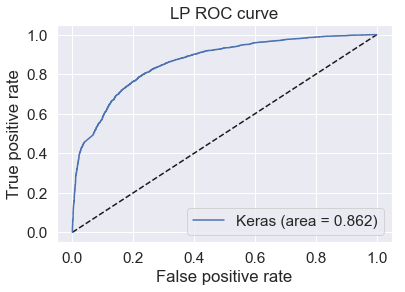

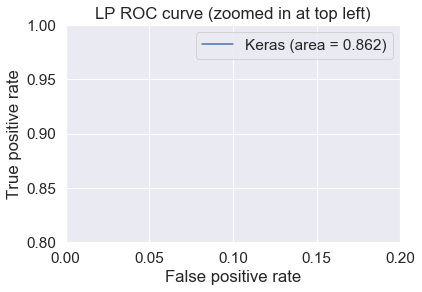

In [34]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true[0:8672], y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LP ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LP ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix
y_pred_keras_test = y_pred_keras 
y_pred_keras_test = np.round(y_pred_keras_test)
cm_out = confusion_matrix(y_true[0:8672], y_pred_keras_test)
print(cm_out)

[[3934  386]
 [1938 2414]]


Text(0.5, 1.0, 'LP Confusion Matrix Normalized to Class')

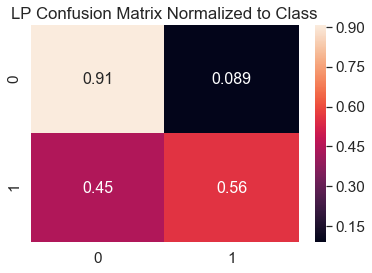

In [39]:
import seaborn as sn
normal = len(y_pred_keras_test)/2    
df_cm = pd.DataFrame(cm_out/normal, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}).set_title("LP Confusion Matrix Normalized to Class")# font size

(120, 120, 3)
(120, 120, 3)
(120, 120, 3)
(120, 120, 3)
(120, 120, 3)
(120, 120, 3)
(120, 120, 3)
(120, 120, 3)
(120, 120, 3)


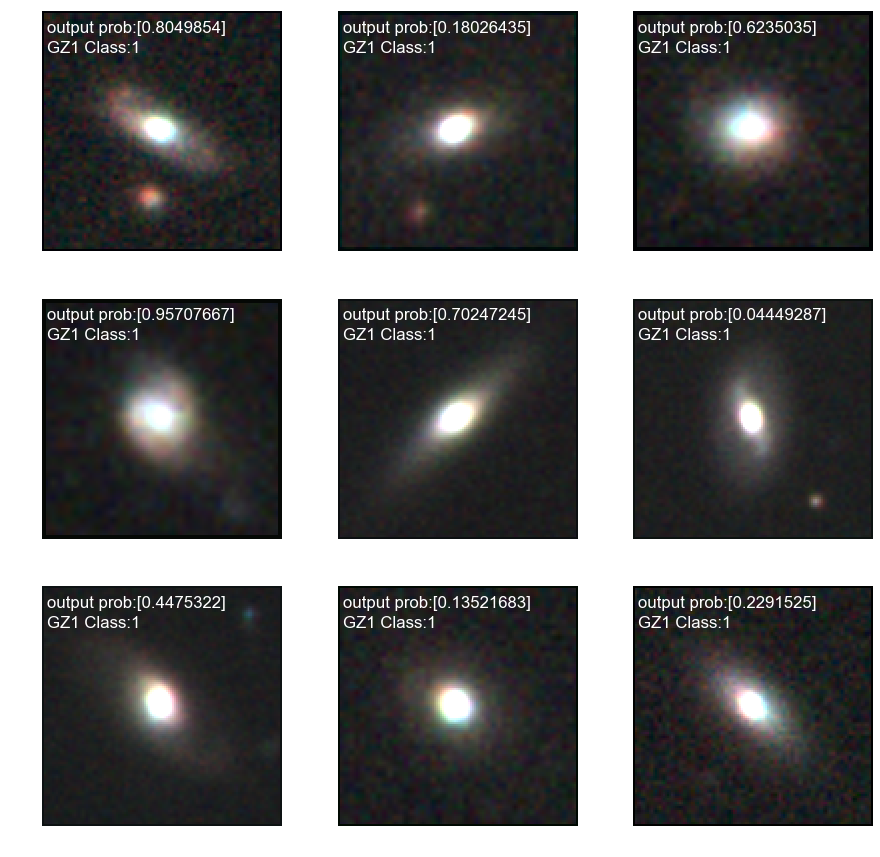

In [119]:
plt.subplots(3,3,figsize=(15,15))

plt.subplot(331)
array = np.load('LP_inputs/' + LP_test_generator.list_IDs[1] + '.npy')[:,:,1:4]
print(np.shape(array))
plt.imshow(array)
plt.text(s=("output prob:" + str(y_pred_keras[1])),x=2,y=10,color='w')
plt.text(s=('GZ1 Class:' + str(1)),x=2,y=20,color='w')
plt.axis('off')
plt.grid(b=None)
plt.subplot(332)
array = np.load('LP_inputs/' + LP_test_generator.list_IDs[3] + '.npy')[:,:,1:4]
print(np.shape(array))
plt.imshow(array)
plt.text(s=("output prob:" + str(y_pred_keras[3])),x=2,y=10,color='w')
plt.text(s=('GZ1 Class:' + str(1)),x=2,y=20,color='w')
plt.axis('off')
plt.grid(b=None)
plt.subplot(333)
array = np.load('LP_inputs/' + LP_test_generator.list_IDs[4] + '.npy')[:,:,1:4]
print(np.shape(array))
plt.imshow(array)
plt.text(s=("output prob:" + str(y_pred_keras[4])),x=2,y=10,color='w')
plt.text(s=('GZ1 Class:' + str(1)),x=2,y=20,color='w')
plt.axis('off')
plt.grid(b=None)
plt.subplot(334)
array = np.load('LP_inputs/' + LP_test_generator.list_IDs[5] + '.npy')[:,:,1:4]
print(np.shape(array))
plt.imshow(array)
plt.text(s=("output prob:" + str(y_pred_keras[5])),x=2,y=10,color='w')
plt.text(s=('GZ1 Class:' + str(1)),x=2,y=20,color='w')
plt.axis('off')
plt.grid(b=None)
plt.subplot(335)
array = np.load('LP_inputs/' + LP_test_generator.list_IDs[9] + '.npy')[:,:,1:4]
print(np.shape(array))
plt.imshow(array)
plt.text(s=("output prob:" + str(y_pred_keras[9])),x=2,y=10,color='w')
plt.text(s=('GZ1 Class:' + str(1)),x=2,y=20,color='w')
plt.axis('off')
plt.grid(b=None)
plt.subplot(336)
array = np.load('LP_inputs/' + LP_test_generator.list_IDs[13] + '.npy')[:,:,1:4]
print(np.shape(array))
plt.imshow(array)
plt.text(s=("output prob:" + str(y_pred_keras[13])),x=2,y=10,color='w')
plt.text(s=('GZ1 Class:' + str(1)),x=2,y=20,color='w')
plt.axis('off')
plt.grid(b=None)
plt.subplot(337)
array = np.load('LP_inputs/' + LP_test_generator.list_IDs[14] + '.npy')[:,:,1:4]
print(np.shape(array))
plt.imshow(array)
plt.text(s=("output prob:" + str(y_pred_keras[14])),x=2,y=10,color='w')
plt.text(s=('GZ1 Class:' + str(1)),x=2,y=20,color='w')
plt.axis('off')
plt.grid(b=None)
plt.subplot(338)
array = np.load('LP_inputs/' + LP_test_generator.list_IDs[15] + '.npy')[:,:,1:4]
print(np.shape(array))
plt.imshow(array)
plt.text(s=("output prob:" + str(y_pred_keras[15])),x=2,y=10,color='w')
plt.text(s=('GZ1 Class:' + str(1)),x=2,y=20,color='w')
plt.axis('off')
plt.grid(b=None)

plt.subplot(339)
array = np.load('LP_inputs/' + LP_test_generator.list_IDs[18] + '.npy')[:,:,1:4]
print(np.shape(array))
plt.imshow(array)
plt.text(s=("output prob:" + str(y_pred_keras[18])),x=2,y=10,color='w')
plt.text(s=('GZ1 Class:' + str(1)),x=2,y=20,color='w')

plt.axis('off')
plt.grid(b=None)
plt.show()

<h1>Now do the same analysis for the HP test</h1>

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
#test on LP inputs.
model.load_weights("models//5-band-CNN-correct-filters-little-more.hdf5")
#need to load in the LP inputs.
y_pred_keras = model.predict_generator(generator=test_generator,
                    steps=test_steps_to_take, 
                    verbose=1)


C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  1/241 [..............................] - ETA: 12:54

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  2/241 [..............................] - ETA: 11:49

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  3/241 [..............................] - ETA: 11:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  4/241 [..............................] - ETA: 12:01

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  5/241 [..............................] - ETA: 11:44

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  6/241 [..............................] - ETA: 11:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  7/241 [..............................] - ETA: 11:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  8/241 [..............................] - ETA: 11:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

  9/241 [>.............................] - ETA: 11:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 10/241 [>.............................] - ETA: 11:35

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 11/241 [>.............................] - ETA: 11:33

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 12/241 [>.............................] - ETA: 11:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 13/241 [>.............................] - ETA: 11:27

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 14/241 [>.............................] - ETA: 11:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 15/241 [>.............................] - ETA: 11:21

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 16/241 [>.............................] - ETA: 11:18

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 17/241 [=>............................] - ETA: 11:14

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 18/241 [=>............................] - ETA: 11:08

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 19/241 [=>............................] - ETA: 11:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 20/241 [=>............................] - ETA: 11:03

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 21/241 [=>............................] - ETA: 10:58

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 22/241 [=>............................] - ETA: 10:54

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 23/241 [=>............................] - ETA: 10:54

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 24/241 [=>............................] - ETA: 10:51

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 25/241 [==>...........................] - ETA: 10:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 26/241 [==>...........................] - ETA: 10:45

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 27/241 [==>...........................] - ETA: 10:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 28/241 [==>...........................] - ETA: 10:40

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 29/241 [==>...........................] - ETA: 10:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 30/241 [==>...........................] - ETA: 10:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 31/241 [==>...........................] - ETA: 10:33

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 32/241 [==>...........................] - ETA: 10:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 33/241 [===>..........................] - ETA: 10:26

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 34/241 [===>..........................] - ETA: 10:24

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 35/241 [===>..........................] - ETA: 10:21

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 36/241 [===>..........................] - ETA: 10:17

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 37/241 [===>..........................] - ETA: 10:15

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 38/241 [===>..........................] - ETA: 10:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 39/241 [===>..........................] - ETA: 10:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 40/241 [===>..........................] - ETA: 10:08

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 41/241 [====>.........................] - ETA: 10:04

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 42/241 [====>.........................] - ETA: 10:01

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 43/241 [====>.........................] - ETA: 9:58 

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 44/241 [====>.........................] - ETA: 9:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 45/241 [====>.........................] - ETA: 9:53

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 46/241 [====>.........................] - ETA: 9:49

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 47/241 [====>.........................] - ETA: 9:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 48/241 [====>.........................] - ETA: 9:43

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 49/241 [=====>........................] - ETA: 9:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 50/241 [=====>........................] - ETA: 9:38

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 51/241 [=====>........................] - ETA: 9:36

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 52/241 [=====>........................] - ETA: 9:33

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 53/241 [=====>........................] - ETA: 9:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 54/241 [=====>........................] - ETA: 9:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 55/241 [=====>........................] - ETA: 9:25

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 56/241 [=====>........................] - ETA: 9:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 57/241 [======>.......................] - ETA: 9:19

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 58/241 [======>.......................] - ETA: 9:17

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 59/241 [======>.......................] - ETA: 9:14

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 60/241 [======>.......................] - ETA: 9:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 61/241 [======>.......................] - ETA: 9:11

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 62/241 [======>.......................] - ETA: 9:10

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 63/241 [======>.......................] - ETA: 9:08

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 64/241 [======>.......................] - ETA: 9:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 65/241 [=======>......................] - ETA: 9:04

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 66/241 [=======>......................] - ETA: 9:02

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 67/241 [=======>......................] - ETA: 9:00

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 68/241 [=======>......................] - ETA: 8:58

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 69/241 [=======>......................] - ETA: 8:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 70/241 [=======>......................] - ETA: 8:55

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 71/241 [=======>......................] - ETA: 8:52

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 72/241 [=======>......................] - ETA: 8:50

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 73/241 [========>.....................] - ETA: 8:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 74/241 [========>.....................] - ETA: 8:45

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 75/241 [========>.....................] - ETA: 8:43

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 76/241 [========>.....................] - ETA: 8:41

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 77/241 [========>.....................] - ETA: 8:39

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 78/241 [========>.....................] - ETA: 8:37

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 79/241 [========>.....................] - ETA: 8:35

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 80/241 [========>.....................] - ETA: 8:34

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 81/241 [=========>....................] - ETA: 8:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 82/241 [=========>....................] - ETA: 8:29

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 83/241 [=========>....................] - ETA: 8:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 84/241 [=========>....................] - ETA: 8:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 85/241 [=========>....................] - ETA: 8:31

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 86/241 [=========>....................] - ETA: 8:30

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 87/241 [=========>....................] - ETA: 8:28

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 88/241 [=========>....................] - ETA: 8:27

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 89/241 [==========>...................] - ETA: 8:26

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 90/241 [==========>...................] - ETA: 8:24

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 91/241 [==========>...................] - ETA: 8:22

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 92/241 [==========>...................] - ETA: 8:19

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 93/241 [==========>...................] - ETA: 8:16

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 94/241 [==========>...................] - ETA: 8:13

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 95/241 [==========>...................] - ETA: 8:11

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 96/241 [==========>...................] - ETA: 8:09

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 97/241 [===========>..................] - ETA: 8:06

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 98/241 [===========>..................] - ETA: 8:04

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

 99/241 [===========>..................] - ETA: 8:01

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

100/241 [===========>..................] - ETA: 7:58

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

101/241 [===========>..................] - ETA: 7:56

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

102/241 [===========>..................] - ETA: 7:53

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

103/241 [===========>..................] - ETA: 7:50

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

104/241 [===========>..................] - ETA: 7:47

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

105/241 [============>.................] - ETA: 7:45

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

106/241 [============>.................] - ETA: 7:42

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

107/241 [============>.................] - ETA: 7:40

C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\awe2\AppData\Local\Continuum\anaconda

In [ ]:
IDs = test_generator.list_IDs
y_true = []
for i in range(len(IDs)):
    y_true.append(test_generator.labels[IDs[i]])
    
HP_prob_Dict = np.load('HP_dict.npy')
HP_prob_Dict = HP_prob_Dict.item()

In [ ]:
y_pred_keras_new = y_pred_keras

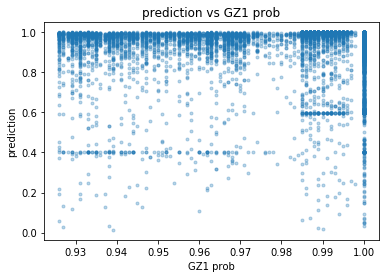

In [38]:
GZ1_prob = []
for i,name in enumerate(test_generator.list_IDs):
    GZ1_prob.append(HP_prob_Dict[name])
    if test_generator.labels[name] == 0 and i < 7712:
        y_pred_keras_new[i] = 1 - y_pred_keras[i]

plt.plot(GZ1_prob[0:7712],y_pred_keras_new,'.', alpha=0.3)
plt.xlabel('GZ1 prob')
plt.ylabel('prediction')
plt.title('prediction vs GZ1 prob')
plt.show()

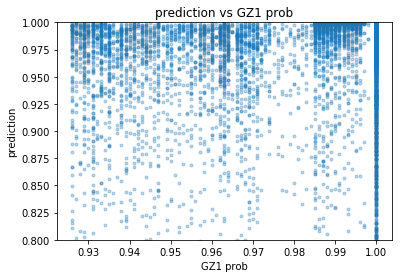

In [40]:
plt.plot(GZ1_prob[0:7712],y_pred_keras_new,'.', alpha=0.3)
plt.xlabel('GZ1 prob')
plt.ylabel('prediction')
plt.title('prediction vs GZ1 prob')
plt.ylim(0.8,1.0)
plt.show()

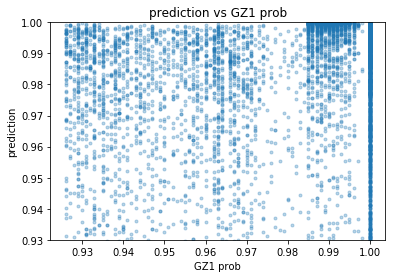

In [44]:
plt.plot(GZ1_prob[0:7712],y_pred_keras_new,'.', alpha=0.3)
plt.xlabel('GZ1 prob')
plt.ylabel('prediction')
plt.title('prediction vs GZ1 prob')
plt.ylim(0.93,1.0)
plt.show()

In [43]:
j=0
for i in range(len(y_pred_keras_new)):
    if y_pred_keras_new[i] < GZ1_prob[i]:
        j=j+1
print(j)

5041


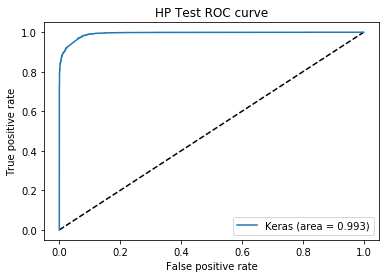

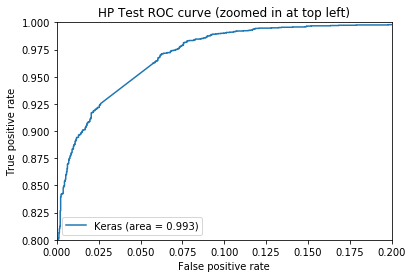

In [24]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true[0:7712], y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('HP Test ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('HP Test ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred_keras_test = y_pred_keras 
y_pred_keras_test = np.round(y_pred_keras_test)
cm_out = confusion_matrix(y_true[0:7712], y_pred_keras_test)

normal = len(y_pred_keras_test)/2
print(cm_out/normal)

import seaborn as sn
      
df_cm = pd.DataFrame(cm_out/normal, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}).set_title("HP Confusion Matrix Normalized by Class")# font size